In [1189]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [1190]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/16h5/s_yaw_16h5_5m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [1191]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [1192]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,7.194353
1,0.943597,46.301006
2,0.945098,7.120405
3,1.846445,79.748564
4,1.846483,6.346697
...,...,...
361,145.428661,74.312673
362,145.428704,-8.477101
363,145.821823,75.477664
364,146.227887,14.611593


In [1193]:
# remove some rows due to a video error
df = df[~df.relative_time.between(66, 70, inclusive=True)].reset_index()

/tmp/ipykernel_38654/1001537679.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df = df[~df.relative_time.between(66, 70, inclusive=True)].reset_index()


<AxesSubplot:xlabel='relative_time'>

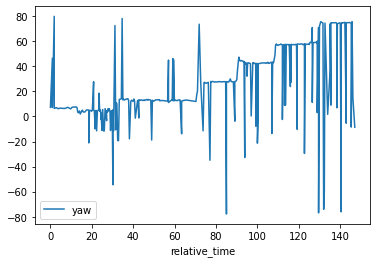

In [1194]:
# initial graph
df.plot(x='relative_time', y=target)

In [1195]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 20)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [1196]:
# the amount of data points we are left with
len(x[peaks])

74

In [1197]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

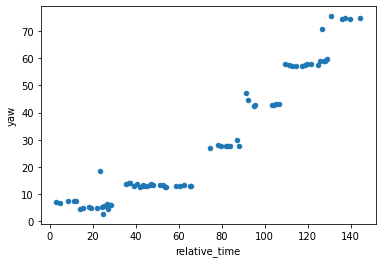

In [1198]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [1199]:
df_filtered_by_targets[true_value] = pd.qcut(np.fix(df_filtered_by_targets[target]/10), len(input_vals)+3, labels=input_vals, duplicates='drop')


In [1200]:
# remove errors as they are not really outliers
a = df_filtered_by_targets.yaw
df_filtered_by_targets.drop(a.loc[(a.diff() > 10) & (a.diff(periods=-1) > 10)].index, inplace=True)

In [1201]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,index,relative_time,yaw,true_yaw
5,5,2.831557,7.023628,0
7,7,4.587236,6.601743,0
11,11,8.331550,7.271862,0
14,14,11.224665,7.495368,0
16,16,12.194410,7.591615,0
21,21,14.041076,4.361295,0
24,24,15.477970,5.037449,0
28,28,18.234918,5.249027,0
32,32,19.193971,4.914087,0
40,40,21.951257,4.812910,0


In [1202]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [1203]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [1204]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,index,relative_time,yaw,true_yaw,error
5,5,2.831557,7.023628,0,-7.023628
7,7,4.587236,6.601743,0,-6.601743
81,81,35.309326,13.832781,15,1.167219
85,85,36.801286,13.920242,15,1.079758
168,180,74.627287,27.092403,30,2.907597
176,188,78.324049,27.904013,30,2.095987
205,217,91.119744,47.223988,45,-2.223988
208,220,92.227313,44.560829,45,0.439171
253,265,109.231097,57.747265,60,2.252735
258,270,111.253690,57.653513,60,2.346487


In [1205]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,17.0,-5.680218,1.310285,-7.591615,-6.601743,-5.535231,-4.914087,-2.649060
15,21.0,1.743694,0.408623,0.907166,1.534916,1.781654,1.976719,2.342153
30,8.0,2.103836,0.843932,0.098007,2.215776,2.312944,2.414535,2.907597
45,8.0,1.402526,1.601893,-2.223988,1.475204,2.042729,2.293326,2.492631
60,13.0,1.940738,0.857099,0.081529,1.069511,2.263056,2.539408,2.736242
75,5.0,0.146688,0.359852,-0.479703,0.209205,0.245965,0.334726,0.423247


In [1206]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

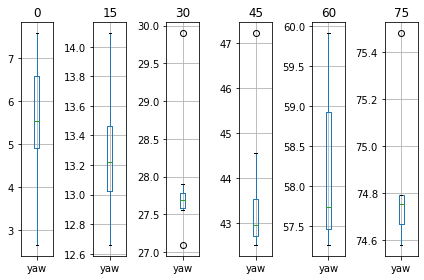

In [1207]:
box_plotter(target)

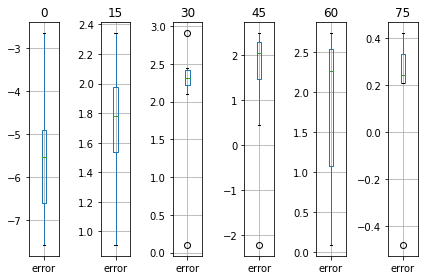

In [1208]:
box_plotter('error')